## Import required packages 

In [1]:
import pandas as pd 
import numpy as np

import requests

import warnings

import time

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from itertools import permutations

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

import logging
import sys

from prophet import Prophet

%matplotlib inline

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Extract stock prices for each 

In [2]:
def get_stock_prices(api_key, tckr ): 
    '''
    Input 
    api_key - unique key from polgon.io that you get for signin up
    tckr - the stock that values need to be extracted 

    Ouput 
    df - volume, price, open, close, high and low stock prices for the stock for each day for the previous 2 years 
         (2 years is the maxiumum time span for the free trial of polygon.io )
    '''
    url = f'https://api.polygon.io/v2/aggs/ticker/{tckr}/range/1/day/2023-01-19/2025-01-19?apiKey={api_key}'
    
    response = requests.get(url)
    data = response.json()
    
    # Convert the JSON data to a pandas DataFrame
    df = pd.DataFrame(data['results'])
    
    # Convert the timestamp to a readable date format
    df['t'] = pd.to_datetime(df['t'], unit='ms')
    
    # Display the historical data
    return df

In [3]:
api_key = 'BIf89HTb0NaGQsWozgDr5x1W8GfFC3MH'
# Choose 4 stores that are closest competitors as we can only download 5 a min with the free API 
stocks = ['GLW','APH','DLB','LFUS','ROG']

stock_prices_df = pd.DataFrame([])

for tckr in stocks:
    stock_prices_df_pre = get_stock_prices(api_key, tckr)
    stock_prices_df_pre.columns = [f"{col}_{tckr}" if col != 't' else col for col in stock_prices_df_pre.columns]
    if stock_prices_df.empty:
        stock_prices_df = stock_prices_df_pre
    else:
        stock_prices_df = stock_prices_df.merge(stock_prices_df_pre, on='t', how='outer')

pred_stock = 'o_GLW'

In [4]:
stock_prices_df.head()

,v_GLW,vw_GLW,o_GLW,c_GLW,h_GLW,l_GLW,t,n_GLW,v_APH,vw_APH,...,h_LFUS,l_LFUS,n_LFUS,v_ROG,vw_ROG,o_ROG,c_ROG,h_ROG,l_ROG,n_ROG
0,4588693.0,36.8311,36.33,36.80,37.040,36.295,2023-01-27 05:00:00,41879,5188690.0,39.2769,...,256.3700,250.20,3688,178757.0,135.9170,134.76,136.57,136.570,134.760,5286
1,6646356.0,36.6320,36.62,36.39,37.100,36.330,2023-01-30 05:00:00,50764,3428662.0,39.1818,...,251.8999,246.27,3356,253643.0,136.4623,135.24,137.19,137.295,135.040,6072
2,14063381.0,34.7587,36.39,34.61,36.390,34.420,2023-01-31 05:00:00,85245,3985268.0,39.6540,...,257.4400,246.75,4304,292621.0,139.0927,137.02,139.59,140.820,136.000,6958
3,6855265.0,35.1585,34.52,35.28,35.590,34.220,2023-02-01 05:00:00,64659,4589076.0,40.2755,...,264.3700,256.29,4942,250997.0,138.7420,139.22,139.16,140.940,136.750,6351
4,4848807.0,35.9855,35.49,36.29,36.335,34.980,2023-02-02 05:00:00,43933,5367528.0,40.9325,...,278.1800,243.86,7619,1125417.0,130.1767,140.22,143.76,144.090,139.225,10421


## See if any data is missing 

In [5]:
stock_prices_df.isna().sum().sum()

np.int64(0)

In [6]:
stock_prices_df.isin([np.inf, -np.inf]).sum().sum()

np.int64(0)

In [7]:
# No missing data, all has been pulled through from the API 

## Explore the data 

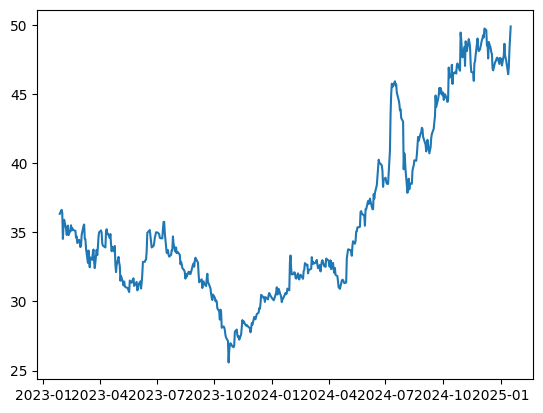

In [8]:
# look at trend over time 
plt.plot(stock_prices_df['t'],stock_prices_df[pred_stock])

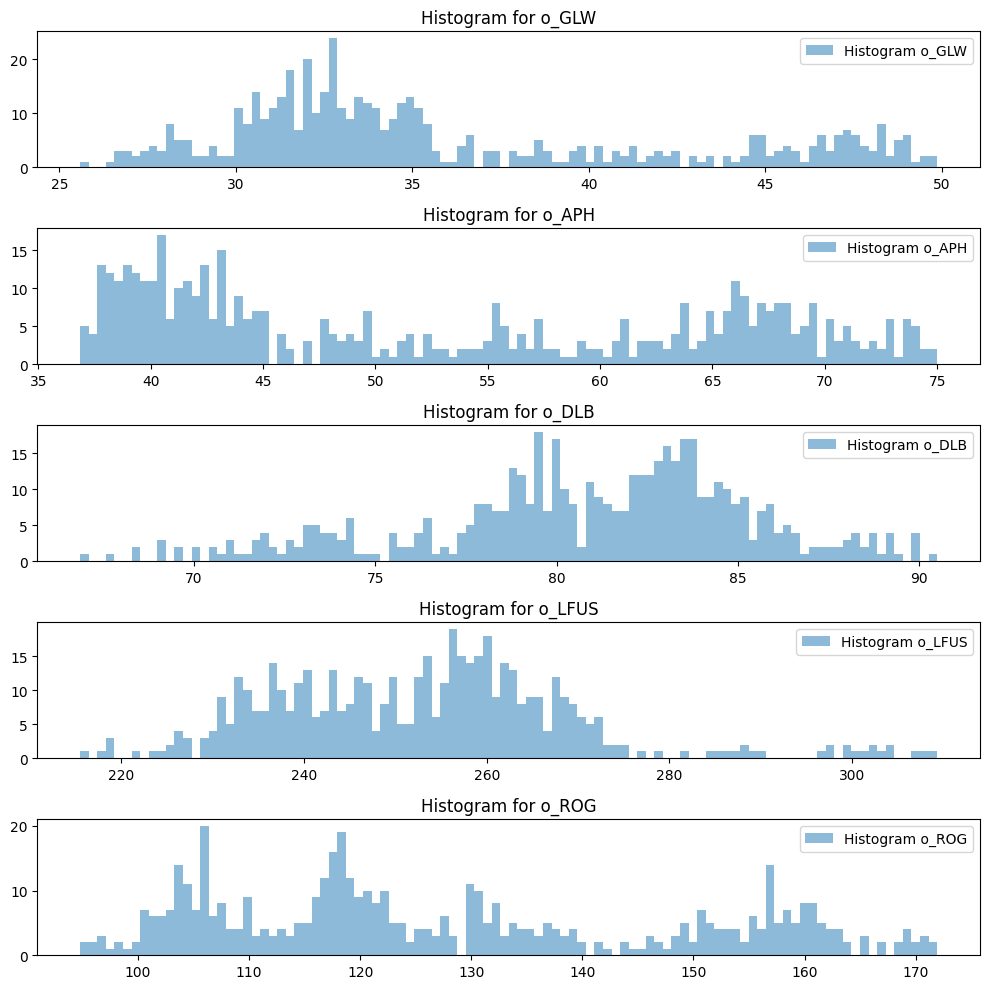

In [9]:
# Most stocks are not normally distributed so make sure methods do not include this 
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for i, tckr in enumerate(stocks[:5]):
    tckr = 'o_' + tckr 
    axs[i].hist(stock_prices_df[tckr], bins=100, alpha=0.5, label=f'Histogram {tckr}')
    axs[i].set_title(f'Histogram for {tckr}')
    axs[i].legend()

plt.tight_layout()
plt.show()

## Auto regression 
Understand if previous values in previous time series contribute to fucture 

In [10]:
def autocorrelation_check(df, target_col, col, min_lag=5, max_lag=50):
    correlations = []
    lagged_cols = {}
    for lag in range(min_lag, max_lag + 1):
        lagged_cols[f'{col}_lagged_{lag}'] = df[col].shift(lag)
    
    lagged_df = pd.DataFrame(lagged_cols)
    target_series = df[target_col]
    
    for lag in range(min_lag, max_lag + 1):
        correlation = target_series.corr(lagged_df[f'{col}_lagged_{lag}'])
        correlations.append({'lag': lag, 'correlation': correlation})
    
    correlation_df = pd.DataFrame(correlations)
    return correlation_df

def generate_top_correlations(df, target_col=pred_stock, min_lag=5, max_lag=6):
    all_correlations = []
    for col in df.columns:
        if col == 't':
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        correlation_df['column'] = col
        all_correlations.append(correlation_df)
    
    all_correlations_df = pd.concat(all_correlations)
    
    # Get the top one correlation from each column by magnitude
    top_correlations = all_correlations_df.loc[all_correlations_df.groupby('column')['correlation'].apply(lambda x: x.abs().idxmax())]
    
    # Select only the relevant columns
    top_correlations = top_correlations[['column', 'lag', 'correlation']]
    
    return top_correlations

In [11]:
top_corr_columns = generate_top_correlations(stock_prices_df,max_lag = 28 * 6)

In [12]:
def plot_correlations(df, target_col=pred_stock, min_lag=5, max_lag=50):
    for col in df.columns:
        if col == 't' :
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        plt.figure(figsize=(10, 1))
        plt.plot(correlation_df['lag'], correlation_df['correlation'], marker='o')
        plt.title(f'Lag vs Correlation for {col}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        plt.grid(True)
        plt.show()

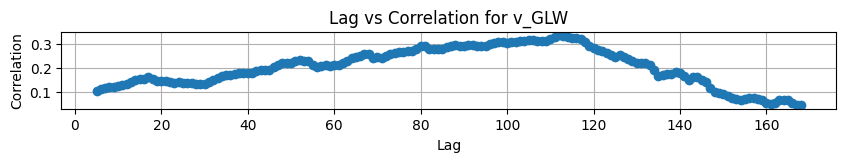

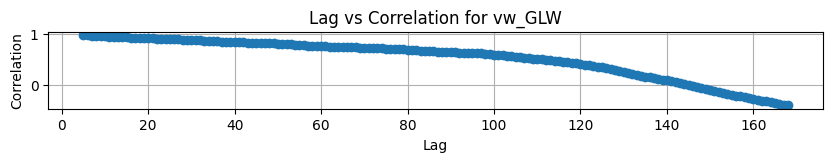

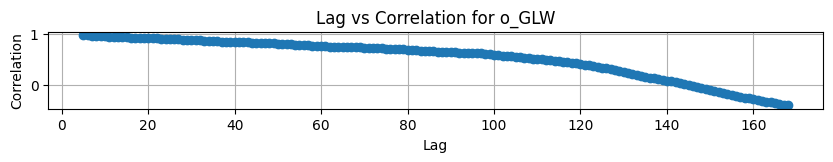

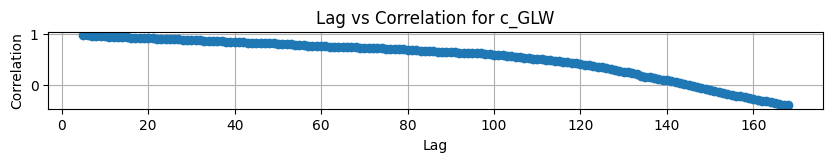

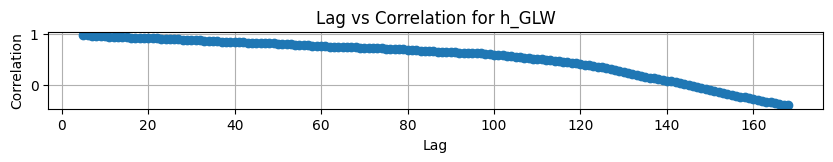

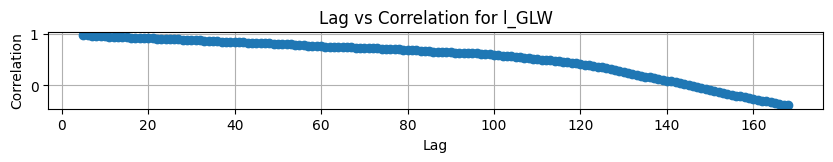

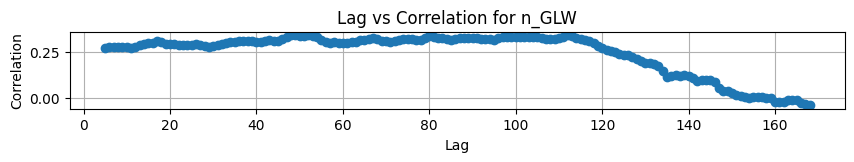

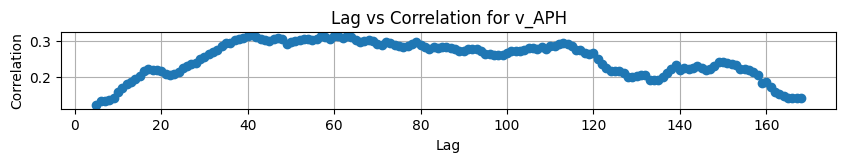

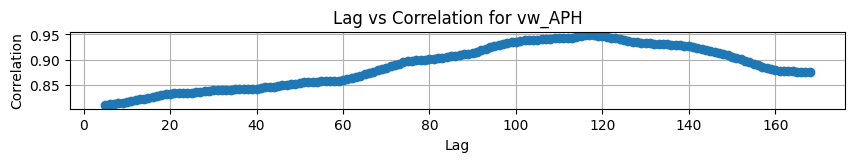

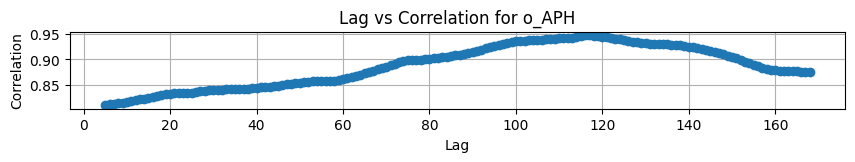

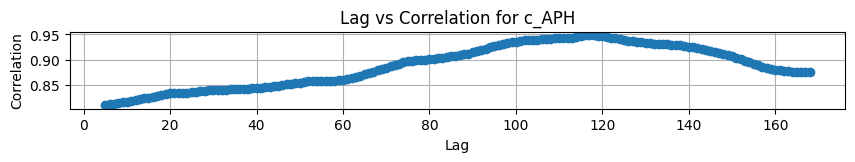

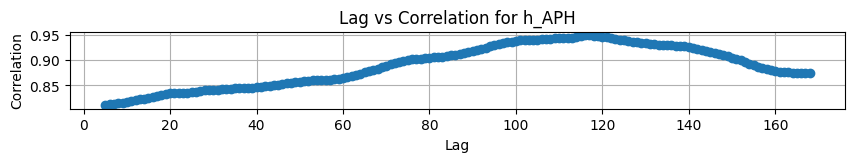

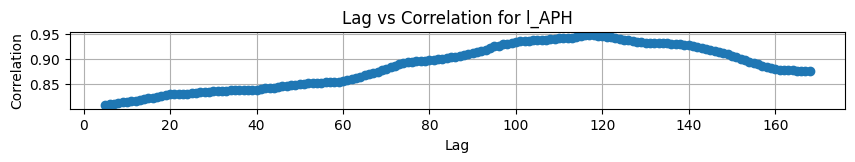

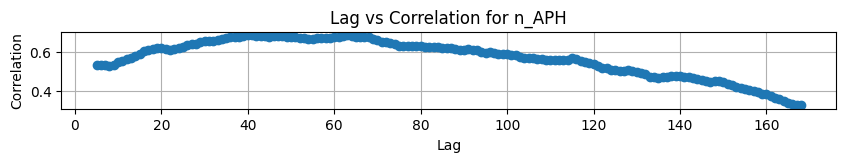

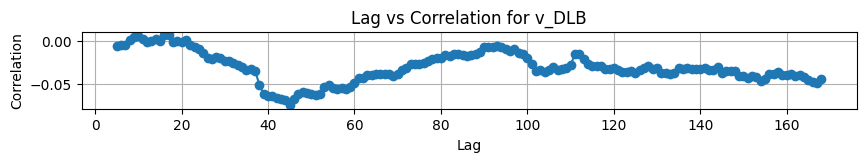

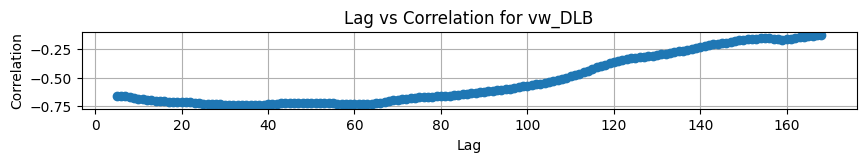

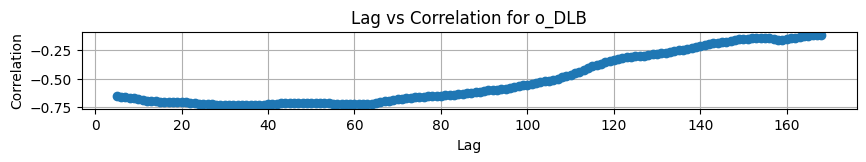

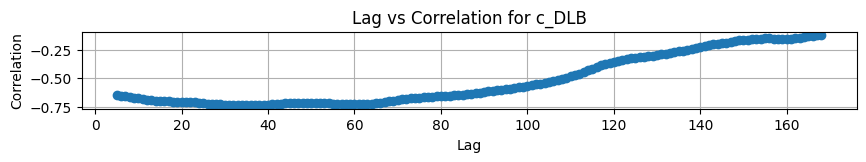

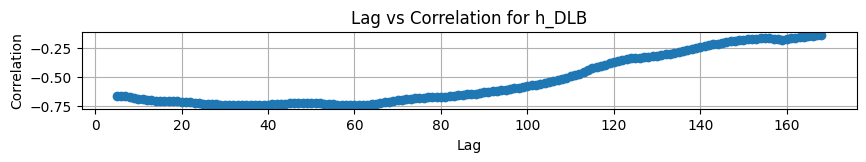

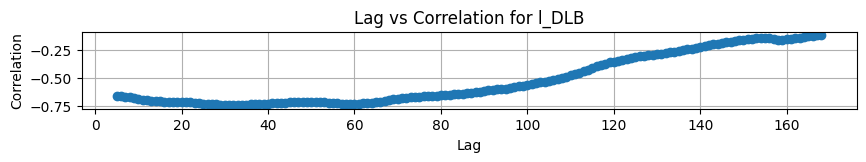

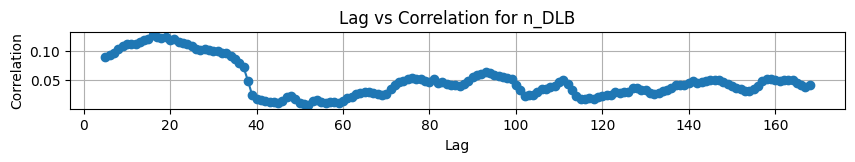

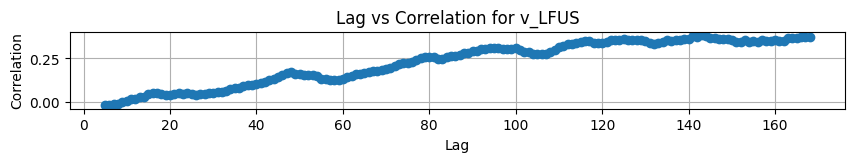

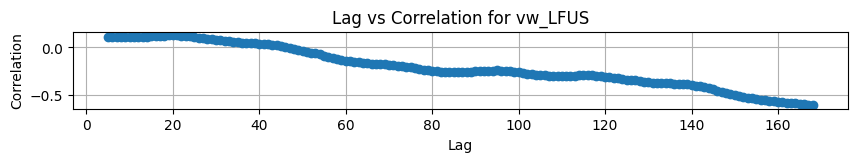

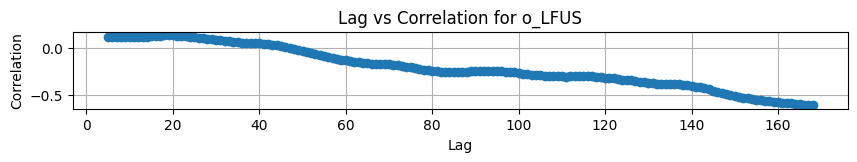

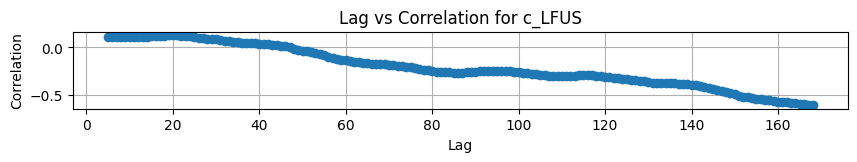

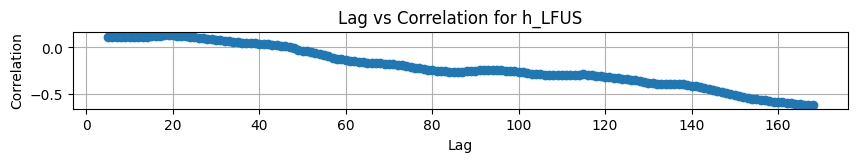

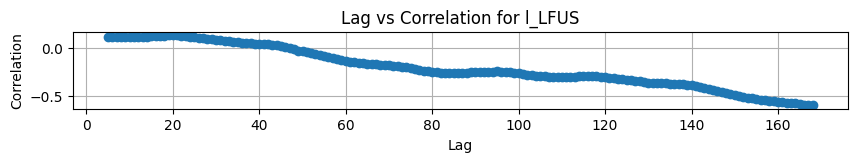

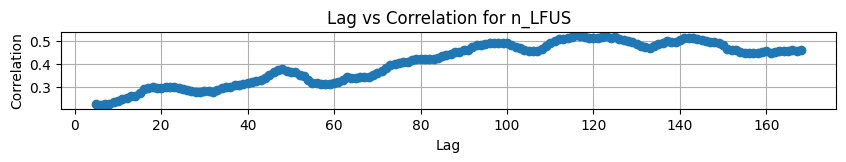

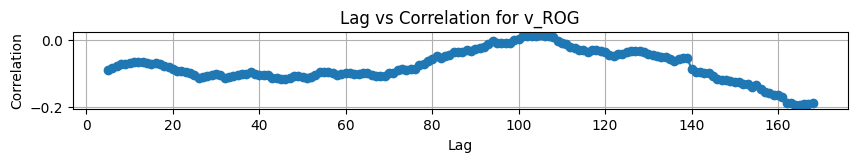

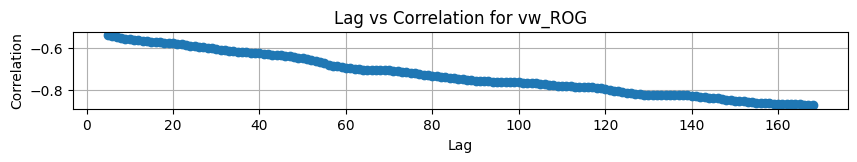

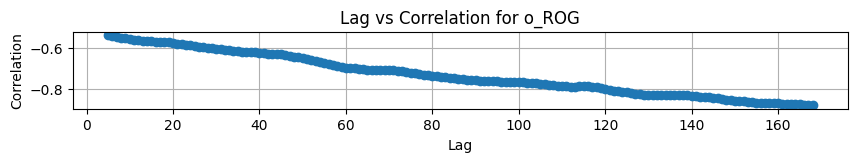

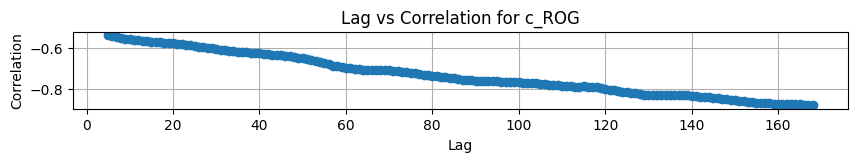

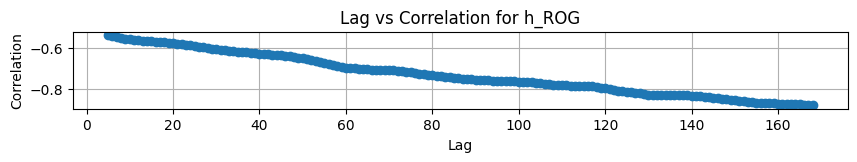

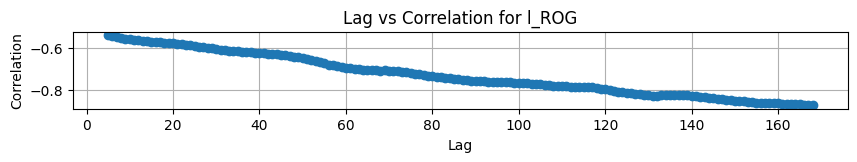

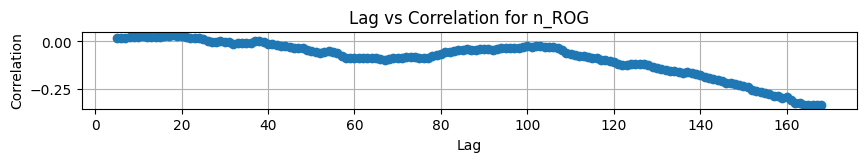

In [13]:
# Only a few double peaks so maxiumum can be used
plot_correlations(stock_prices_df,max_lag = 28 * 6)

In [14]:
top_corr_columns

,column,lag,correlation
112,v_GLW,117,0.317961
112,vw_GLW,117,0.449136
112,o_GLW,117,0.446172
112,c_GLW,117,0.451336
112,h_GLW,117,0.445651
...,...,...,...
163,o_ROG,168,-0.876213
163,c_ROG,168,-0.876740
163,h_ROG,168,-0.881543
163,l_ROG,168,-0.872614


In [15]:
lagged_df = pd.DataFrame()

for index, row in top_corr_columns.iterrows():
    column_name = row['column']
    lag_amount = row['lag']
    
    # Shift the column by the specified lag amount
    lagged_column = stock_prices_df[column_name].shift(lag_amount)
    
    # Add the lagged column to the new dataframe
    lagged_df[column_name] = lagged_column

# Drop rows with NaN values resulting from the lagging process
lagged_df.dropna(inplace=True)

In [16]:
# 99% of autocorrelation variation done by 2 previous columns 
pca = PCA(n_components=0.99)
pca_result = pca.fit_transform(lagged_df)

# Convert PCA result to a dataframe
pca_df = pd.DataFrame(pca_result)
pca_df

,0,1,2
0,3.753775e+04,2.711180e+05,-144110.834449
1,2.252531e+05,2.973136e+06,162610.796207
2,5.829351e+06,7.863838e+06,174576.130879
3,1.199889e+06,2.307196e+06,92560.819022
4,3.519763e+05,3.339481e+05,190986.382392
...,...,...,...
323,-1.553913e+06,-6.203094e+05,-142728.535028
324,-2.025416e+06,-8.123180e+05,-147410.329052
325,1.168404e+06,2.050564e+06,97794.914273
326,5.167042e+05,-2.095110e+06,-106077.185772


In [17]:
# Create function for processing data later 

def comp_corr_pca(df, target_col, min_lag=5, max_lag=50):

    # Generate top correlations
    top_corr_columns = generate_top_correlations(df, target_col, min_lag, max_lag)
    
    # Create a new DataFrame for lagged columns
    lagged_df = pd.DataFrame()
    for index, row in top_corr_columns.iterrows():
        column_name = row['column']
        lag_amount = row['lag']
        lagged_df[column_name] = df[column_name].shift(lag_amount)
    lagged_df.dropna(inplace=True)

    # Ensure only numeric columns are used for PCA
    numeric_lagged_df = lagged_df.select_dtypes(include=['number'])

    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=0.99)
    pca_result = pca.fit_transform(numeric_lagged_df)
    pca_df = pd.DataFrame(pca_result, index=lagged_df.index)

    # Add the PCA columns to the original df
    for i in range(pca_df.shape[1]):
        df[f"Competitor_PCA_{i+1}"] = pca_df.iloc[:, i]

    return df

## Excluded Standerd deviation
Later on it may be beneficial to exclude large fluctuation in stock 

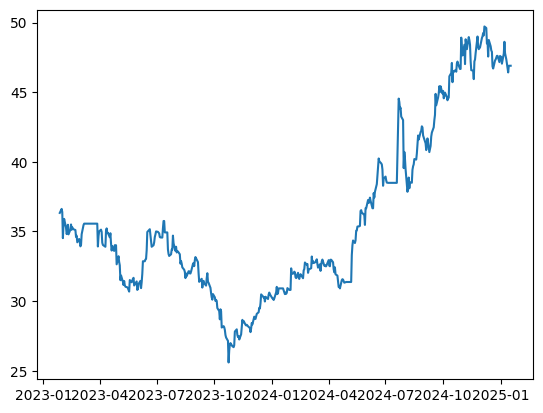

In [18]:
stock_prices_df_plot = stock_prices_df.copy()

# Predicting 5 days into the future so use rolling 5 days standerd deviation 
stock_prices_df_plot[pred_stock + '_std'] =  stock_prices_df_plot[pred_stock].rolling(window=20).std()

# Initialize the last valid value
last_valid_value = stock_prices_df_plot.loc[0, 'o_GLW']

# Create a new column 'o_GLW_no_dev' and copy the original 'o_GLW' values
stock_prices_df_plot['o_GLW_no_dev'] = stock_prices_df_plot['o_GLW']

# Forward fill the previous stock price when the magnitude of the deviation is greater than a threshold
for i in range(1, len(stock_prices_df_plot)):
    threshold = 2 * stock_prices_df_plot.loc[i, 'o_GLW_std']  # Update threshold based on the most recent std
    if abs(stock_prices_df_plot.loc[i, 'o_GLW'] - last_valid_value) > threshold:
        stock_prices_df_plot.loc[i, 'o_GLW_no_dev'] = last_valid_value
    else:
        last_valid_value = stock_prices_df_plot.loc[i, 'o_GLW']

plt.plot(stock_prices_df_plot['t'] ,stock_prices_df_plot['o_GLW_no_dev'])

In [19]:
# Changed to function so can possibly be implemented in the end to improve accuracy 
def remove_deviation(df, target_column):
    

    # Calculate rolling standard deviation
    df[target_column + '_std'] = df[target_column].rolling(window=20).std()

    # Initialize the last valid value
    last_valid_value = df.loc[0, target_column]

    # Create a new column for the adjusted values
    adjusted_column = target_column + '_no_dev'
    df[adjusted_column] = df[target_column]

    # Forward fill the previous stock price when the magnitude of the deviation is greater than a threshold
    for i in range(1, len(df)):
        threshold = 2 * df.loc[i-1, target_column + '_std']  # Update threshold based on the most recent std
        if abs(df.loc[i, target_column] - last_valid_value) > threshold:
            df.loc[i, adjusted_column] = last_valid_value
        else:
            last_valid_value = df.loc[i, target_column]

    return df

## Does std affect later volumes of trading 

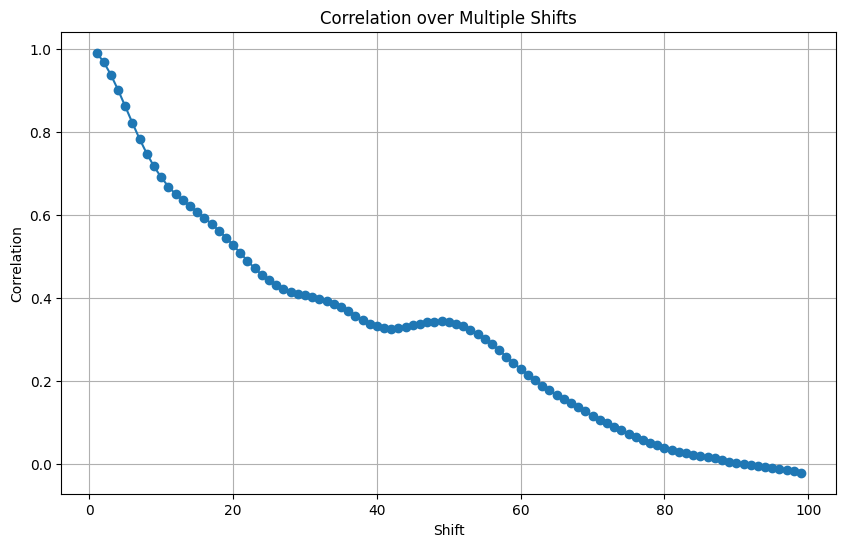

In [20]:
shifts = range(1, 100)
correlations = []

for shift in shifts:
    shifted_column_o_GLW = stock_prices_df_plot['o_GLW'].shift(-shift)
    shifted_column_o_GLW_std = stock_prices_df_plot['o_GLW_std'].shift(-shift)
    
    combined_df = pd.DataFrame({
        'product': stock_prices_df_plot['o_GLW'] * stock_prices_df_plot['o_GLW_std'],
        'shifted_product': shifted_column_o_GLW * shifted_column_o_GLW_std
    }).dropna()
    
    correlation = np.corrcoef(combined_df['product'], combined_df['shifted_product'])[0, 1]
    correlations.append(correlation)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(shifts, correlations, marker='o')
plt.title('Correlation over Multiple Shifts')
plt.xlabel('Shift')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

Peaks at 47 days shows this may be a usefull metric to add

## Pct changes 

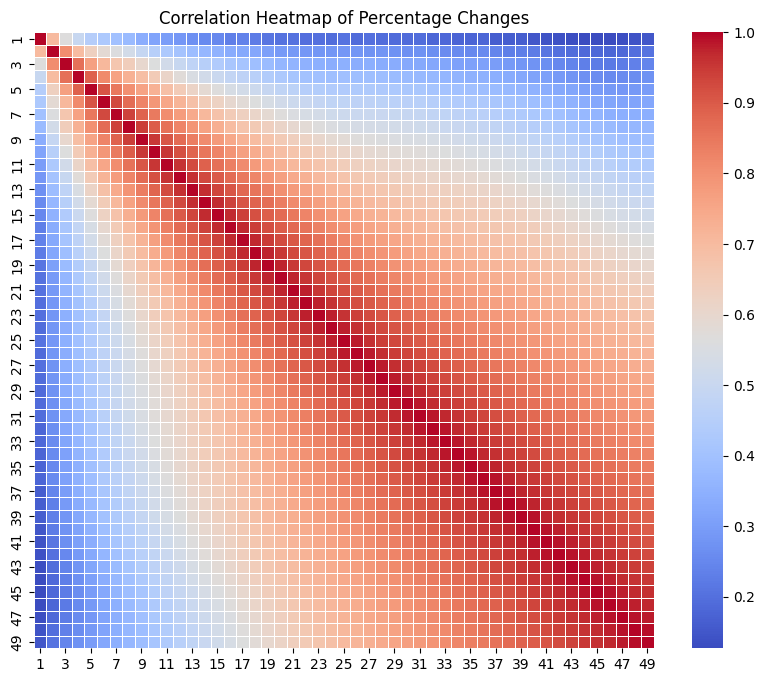

In [21]:
# Create the correlation matrix of percentage changes
pct_change_corr_df = pd.DataFrame([])

for i in range(1, 50):
    pct_change_df = pd.DataFrame(stock_prices_df[pred_stock].pct_change(-i))
    pct_change_df.columns = [str(i)]
    pct_change_corr_df = pd.concat([pct_change_corr_df, pct_change_df], axis=1)

corr_matrix = pct_change_corr_df.corr()

# Generate a heatmap with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Percentage Changes')
plt.show()

In [22]:
# Introduce on the most recent pct changes to the data
# We start to see very low correlations after 20 days to this will be the max 

def pct_change(df,target_col):
    '''
    Input 
    df - Stock dataframe
    target_col - target column you wish to get pct changes from

    Ouput
    df - original data frame with pct changes for 1,5,10 and 20 days 

    '''

    df[target_col + '_1_day_pct_chng'] = df[target_col].pct_change(-1)
    df[target_col + '_5_day_pct_chng'] = df[target_col].pct_change(-5)
    df[target_col + '_10_day_pct_chng'] = df[target_col].pct_change(-10)
    df[target_col + '_20_day_pct_chng'] = df[target_col].pct_change(-20)

    return df

## Loss aversion 
- Works on the percent change to identify the fact that dips in stock price are seen as worse than gains 

In [23]:
def loss_aversion_change(df, target_col):
    '''
    Input 
    df - Stock dataframe
    target_col - target column you wish to get pct changes from

    Ouput
    df - original data frame with the loss aversion function equation applied 

    '''

    def loss_aversion_function(x, alpha=0.88, beta=0.88, lambda_=2.5):
        if x >= 0:
            return x ** alpha
        else:
            return -lambda_ * (-x) ** beta
    
    df['loss_averse_' + target_col] = df[target_col].apply(lambda x: loss_aversion_function(x))

    return df

## Moving averages and time series analysis

In [24]:
def calculate_mse(df, window, prediction_days, method='MA'):
    df = df.copy() 
    
    if method == 'MA':
        df['average'] = df[pred_stock].rolling(window=window).mean()
    elif method == 'EMA':
        df['average'] = df[pred_stock].ewm(span=window, adjust=False).mean()
    else:
        raise ValueError("Method must be 'MA' or 'EMA'")
    
    mse_list = []
    
    for i in range(len(df) - window - prediction_days + 1):
        actual = df[pred_stock][i + window:i + window + prediction_days].values
        predicted = df['average'][i + window:i + window + prediction_days].values
        mse = mean_squared_error(actual, predicted)
        mse_list.append(mse)
    
    return np.mean(mse_list)

def evaluate_mse(stock_prices_df, max_window=28, prediction_days=5, method='MA'):
    results = []

    for window in range(1, max_window + 1):
        mse_list = []
        for start_day in range(len(stock_prices_df) - window - 30, len(stock_prices_df) - window - 5):
            mse = calculate_mse(stock_prices_df.iloc[start_day:], window, prediction_days, method)
            mse_list.append(mse)
        avg_mse = np.mean(mse_list)
        results.append({'window': window, 'mse': avg_mse})

    results_df = pd.DataFrame(results)

    plt.plot(results_df['window'], results_df['mse'])
    plt.xlabel('Window Size')
    plt.ylabel('Mean Squared Error')
    plt.title(f'MSE vs Window Size ({method})')
    plt.show()

    return results_df


### Moving Average 

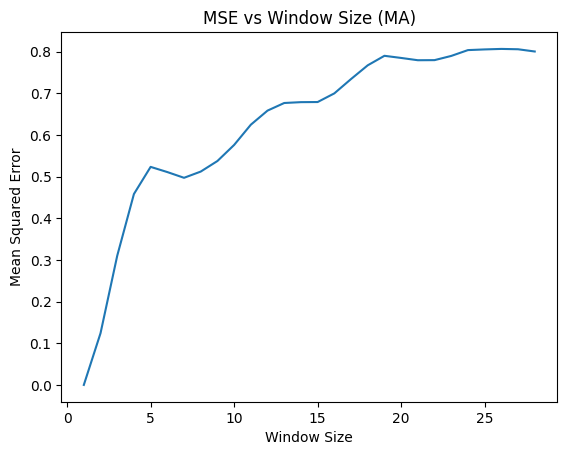

In [25]:
mse_ma = evaluate_mse(stock_prices_df, method='MA')

### Exponential moving average 

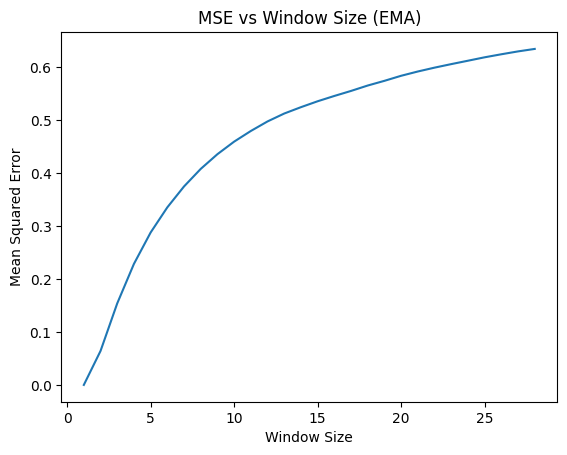

In [26]:
mse_ema = evaluate_mse(stock_prices_df, method='EMA')

### Prophet

In [27]:
# Suppress cmdstanpy INFO messages
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Suppress Prophet INFO messages
logging.getLogger('prophet').setLevel(logging.ERROR)

# Suppress other related INFO messages
logging.getLogger('fbprophet').setLevel(logging.ERROR)

# Function to calculate mean squared error using Prophet
def calculate_mse_prophet(df, prediction_days):
    df = df.copy()  # Avoid modifying the original DataFrame
    df['y'] = df[pred_stock]
    df['ds'] = df['t']
    
    # Fit the model
    model = Prophet()
    model.fit(df[['ds', 'y']])
    
    # Make future dataframe
    future = model.make_future_dataframe(periods=prediction_days)
    
    # Predict
    forecast = model.predict(future)
    
    mse_list = []
    
    for i in range(len(df) - prediction_days + 1):
        actual = df[pred_stock][i:i + prediction_days].values
        predicted = forecast['yhat'][i:i + prediction_days].values
        mse = mean_squared_error(actual, predicted)
        mse_list.append(mse)
    
    return np.mean(mse_list)

# Iterate over all windows up to 28 days and predict 5 days in the future, excluding the last 5 days
results = []

for window in range(1, 29):
    mse_list = []
    for start_day in range(len(stock_prices_df) - window - 30, len(stock_prices_df) - window - 10):  # Exclude the last 5 days
        mse = calculate_mse_prophet(stock_prices_df.iloc[start_day:], 5)
        mse_list.append(mse)
    avg_mse = np.mean(mse_list)
    results.append({'window': window, 'mse': avg_mse})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Plot the results
plt.plot(results_df['window'], results_df['mse'])
plt.xlabel('Window Size')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Window Size (Prophet Prediction)')
plt.show()

19:35:50 - cmdstanpy - INFO - Chain [1] start processing
19:35:50 - cmdstanpy - INFO - Chain [1] done processing
19:35:51 - cmdstanpy - INFO - Chain [1] start processing
19:35:51 - cmdstanpy - INFO - Chain [1] done processing
19:35:51 - cmdstanpy - INFO - Chain [1] start processing
19:35:51 - cmdstanpy - INFO - Chain [1] done processing
19:35:52 - cmdstanpy - INFO - Chain [1] start processing
19:35:52 - cmdstanpy - INFO - Chain [1] done processing
19:35:52 - cmdstanpy - INFO - Chain [1] start processing
19:35:52 - cmdstanpy - INFO - Chain [1] done processing
19:35:52 - cmdstanpy - INFO - Chain [1] start processing
19:35:53 - cmdstanpy - INFO - Chain [1] done processing
19:35:53 - cmdstanpy - INFO - Chain [1] start processing
19:35:53 - cmdstanpy - INFO - Chain [1] done processing
19:35:53 - cmdstanpy - INFO - Chain [1] start processing
19:35:53 - cmdstanpy - INFO - Chain [1] done processing
19:35:54 - cmdstanpy - INFO - Chain [1] start processing
19:35:54 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

- Although Prophet stabilises quicker in its and has lower error overall, we will use EMA ad 5 days lag due to it having the lowest error overall 
- Greater than 5 days will be used due to predicting 5 days into the future

## Variations of model and adjustments to the data

### Add columns to original data frame

In [28]:
stock_prices_model_df = stock_prices_df.copy()

#add stock price with removed deviations
stock_prices_model_df = remove_deviation(stock_prices_model_df,pred_stock)

#Lagged values with competitor stocks and PCA to decrease overfitting 
stock_prices_model_df = comp_corr_pca(stock_prices_model_df,pred_stock)

#Pct_changes
stock_prices_model_df = pct_change(stock_prices_model_df,pred_stock)

#Run loss aversion on the pct changes
for i in ['o_GLW_1_day_pct_chng','o_GLW_5_day_pct_chng','o_GLW_10_day_pct_chng','o_GLW_20_day_pct_chng']:
    stock_prices_model_df = loss_aversion_change(stock_prices_model_df,i)

# Add optimal 5 day rolling average 
stock_prices_model_df[pred_stock + '_EMA'] = stock_prices_model_df[pred_stock].ewm(span=5, adjust=False).mean()

# Add in 47 day lag of std * price as there is a promising correlation between the two 
stock_prices_model_df['o_GLW_std_price'] = stock_prices_model_df['o_GLW_std'].shift(-47) * stock_prices_model_df['o_GLW'].shift(-47)

stock_prices_model_df = stock_prices_model_df.drop(list(stock_prices_df.drop([pred_stock],axis = 1).columns),axis = 1).dropna()

stock_prices_model_df.head()
    

,o_GLW,o_GLW_std,o_GLW_no_dev,Competitor_PCA_1,Competitor_PCA_2,Competitor_PCA_3,o_GLW_1_day_pct_chng,o_GLW_5_day_pct_chng,o_GLW_10_day_pct_chng,o_GLW_20_day_pct_chng,loss_averse_o_GLW_1_day_pct_chng,loss_averse_o_GLW_5_day_pct_chng,loss_averse_o_GLW_10_day_pct_chng,loss_averse_o_GLW_20_day_pct_chng,o_GLW_EMA,o_GLW_std_price
69,31.39,1.237372,31.39,-2.069004e+06,-6.423427e+05,-156774.547068,0.007705,0.012907,0.001276,0.014872,0.013815,0.021754,0.002839,0.024643,31.931189,18.742784
70,31.15,1.284659,31.15,-2.211434e+06,-1.535725e+06,-209516.226341,-0.009224,0.007439,-0.010483,-0.006696,-0.040464,0.013394,-0.045286,-0.030527,31.670793,20.701386
71,31.44,1.262555,31.44,1.557577e+05,8.340801e+05,53499.274404,0.009634,0.020779,-0.005063,-0.015962,0.016817,0.033076,-0.023869,-0.065564,31.593862,21.554459
72,31.14,1.261073,31.14,-9.806531e+05,1.037264e+06,-160886.454988,0.003545,0.014993,-0.016735,-0.052343,0.006977,0.024820,-0.068349,-0.186439,31.442575,23.071829
73,31.03,1.235826,31.03,-1.928634e+06,-1.831106e+06,-234688.920191,0.001291,-0.015233,-0.002892,-0.055691,0.002868,-0.062921,-0.014581,-0.196893,31.305050,24.824523


In [30]:
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

def calculate_metrics(model, train, test, pred_stock):
    model.fit(train.drop(columns=[pred_stock]), train[pred_stock])
    predictions = model.predict(test.drop(columns=[pred_stock]))
    mse = mean_squared_error(test[pred_stock], predictions)
    mae = mean_absolute_error(test[pred_stock], predictions)
    r2 = r2_score(test[pred_stock], predictions)
    return mse, mae, r2

def print_loading_bar(iteration, total, length=50):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r|{bar}| {percent}% Complete')
    sys.stdout.flush()

def evaluate_model_for_windows(model_info, stock_prices_model_df, pred_stock, total_windows=28):
    results = []
    scaler = StandardScaler()
    model = model_info['model']
    grid_search = GridSearchCV(estimator=model, param_grid=model_info['params'], cv=3)
    
    for window in range(1, total_windows + 1):
        start_idx = -30 - (window * 5)
        end_idx = start_idx + 5
        train = stock_prices_model_df.iloc[:start_idx]
        test = stock_prices_model_df.iloc[start_idx:end_idx]
        
        # Normalize the data
        train_scaled = scaler.fit_transform(train.drop(columns=[pred_stock]))
        test_scaled = scaler.transform(test.drop(columns=[pred_stock]))
        
        train_scaled = pd.DataFrame(train_scaled, columns=train.drop(columns=[pred_stock]).columns)
        test_scaled = pd.DataFrame(test_scaled, columns=test.drop(columns=[pred_stock]).columns)
        
        train_scaled[pred_stock] = train[pred_stock].values
        test_scaled[pred_stock] = test[pred_stock].values
        
        grid_search.fit(train_scaled.drop(columns=[pred_stock]), train_scaled[pred_stock])
        
        best_model = grid_search.best_estimator_
        
        mse, mae, r2 = calculate_metrics(best_model, train_scaled, test_scaled, pred_stock)
        results.append({'window': window, 'mse': mse, 'mae': mae, 'r2': r2})
        
        print_loading_bar(window, total_windows)
    
    print()  # Move to the next line after completion
    return results

In [ ]:

models = {
    'neural_network': {
        'model': MLPRegressor(max_iter=200),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'sgd']
        }
    },
    'linear_regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30]
        }
    },
    'xgboost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

total_windows = 28
results = {model_name: evaluate_model_for_windows(model_info, stock_prices_model_df, pred_stock, total_windows) for model_name, model_info in models.items()}

# Calculate average metrics for each model
average_metrics = {}
for model_name, metrics in results.items():
    avg_mse = np.mean([m['mse'] for m in metrics])
    avg_mae = np.mean([m['mae'] for m in metrics])
    avg_r2 = np.mean([m['r2'] for m in metrics])
    average_metrics[model_name] = {'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_r2': avg_r2}

print("Average Metrics for Each Model:")
for model_name, metrics in average_metrics.items():
    print(f"{model_name}: MSE={metrics['avg_mse']}, MAE={metrics['avg_mae']}, R2={metrics['avg_r2']}")

|███-----------------------------------------------| 7.1% Complete

Linear regression has by far the best ouptut most likley due to the smalle sample size we have available with other methods overfitting

In [31]:
# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Assuming 'stock_prices_model_df' is your DataFrame
# Drop the target variable 'pred_stock' from the features
features_df = stock_prices_model_df.drop(columns=[pred_stock])

# Calculate VIF for each feature
vif_df = calculate_vif(features_df)

vif_df

,feature,VIF
0,o_GLW_std,6.475726
1,o_GLW_no_dev,2219.087434
2,Competitor_PCA_1,1.024849
3,Competitor_PCA_2,1.047522
4,Competitor_PCA_3,1.023861
5,o_GLW_1_day_pct_chng,16.240419
6,o_GLW_5_day_pct_chng,33.312354
7,o_GLW_10_day_pct_chng,34.353906
8,o_GLW_20_day_pct_chng,29.555362
9,loss_averse_o_GLW_1_day_pct_chng,17.461876


In [ ]:
for i in stock_prices_model_df.drop(pred_stock,axis = 1).columns:
    results_linear_regression = evaluate_model_for_windows(linear_regression_model_info[[i,pred_stock]], stock_prices_model_df, pred_stock, total_windows)

    average_metrics_linear_regression = {}
    avg_mse = np.mean([m['mse'] for m in results_linear_regression])
    avg_mae = np.mean([m['mae'] for m in results_linear_regression])
    avg_r2 = np.mean([m['r2'] for m in results_linear_regression])
    average_metrics_linear_regression['linear_regression'] = {'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_r2': avg_r2}

In [41]:
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['column', 'avg_mse', 'avg_mae', 'avg_r2'])

# Loop through each column in the DataFrame except the prediction stock column
for i in stock_prices_model_df.drop(pred_stock, axis=1).columns:
    # Evaluate the model for the current column
    results_linear_regression = evaluate_model_for_windows(linear_regression_model_info, stock_prices_model_df[[i, pred_stock]], pred_stock, total_windows)

    # Calculate average metrics
    avg_mse = np.mean([m['mse'] for m in results_linear_regression])
    avg_mae = np.mean([m['mae'] for m in results_linear_regression])
    avg_r2 = np.mean([m['r2'] for m in results_linear_regression])

    # Store the results in the DataFrame
    new_row = pd.DataFrame({'column': [i], 'avg_mse': [avg_mse], 'avg_mae': [avg_mae], 'avg_r2': [avg_r2]})
    results_df = pd.concat([results_df, new_row], ignore_index=True)

|██████████████████████████████████████████████████| 100.0% Complete
|████████████████----------------------------------| 32.1% Complete

C:\Users\benedict.grant\AppData\Local\Temp\ipykernel_3244\1706112881.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete


In [42]:
results_df

,column,avg_mse,avg_mae,avg_r2
0,o_GLW_std,25.712039,4.092733,-200.536066
1,o_GLW_no_dev,3.285419,0.858645,-79.547399
2,Competitor_PCA_1,38.972725,5.115019,-387.950722
3,Competitor_PCA_2,47.902528,5.665628,-469.422369
4,Competitor_PCA_3,46.970227,5.694236,-457.999580
5,o_GLW_1_day_pct_chng,47.872946,5.758276,-458.471688
6,o_GLW_5_day_pct_chng,48.839826,5.834482,-481.744125
7,o_GLW_10_day_pct_chng,49.543956,5.906657,-517.092073
8,o_GLW_20_day_pct_chng,49.980642,6.052808,-487.113577
9,loss_averse_o_GLW_1_day_pct_chng,47.778181,5.751673,-459.287457


In [43]:
# Linear Regression model with intercept=True
linear_regression_model_info = {
    'model': LinearRegression(),
    'params': {
        'fit_intercept': [True]
    }
}

results_linear_regression = evaluate_model_for_windows(linear_regression_model_info, stock_prices_model_df.drop('o_GLW_no_dev',axis = 1), pred_stock, total_windows)

# Calculate average metrics for the linear regression model
average_metrics_linear_regression = {}
avg_mse = np.mean([m['mse'] for m in results_linear_regression])
avg_mae = np.mean([m['mae'] for m in results_linear_regression])
avg_r2 = np.mean([m['r2'] for m in results_linear_regression])
average_metrics_linear_regression['linear_regression'] = {'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_r2': avg_r2}

print("Average Metrics for Linear Regression Model:")
for model_name, metrics in average_metrics_linear_regression.items():
    print(f"{model_name}: MSE={metrics['avg_mse']}, MAE={metrics['avg_mae']}, R2={metrics['avg_r2']}")

|██████████████████████████████████████████████████| 100.0% Complete
Average Metrics for Linear Regression Model:
linear_regression: MSE=0.5697078226082286, MAE=0.48540797227132054, R2=-1.2341539270030673


## Residual analysis

In [45]:
def plot_residuals(results):
    for result in results:
        plt.figure(figsize=(10, 6))
        plt.plot(result['residuals'], marker='o', linestyle='none')
        plt.title(f'Residuals for Window {result["window"]}')
        plt.xlabel('Observation')
        plt.ylabel('Residual')
        plt.show()

# Linear Regression model with intercept=True
linear_regression_model_info = {
    'model': LinearRegression(),
    'params': {
        'fit_intercept': [True]
    }
}

results_linear_regression = evaluate_model_for_windows(linear_regression_model_info, stock_prices_model_df.drop('o_GLW_no_dev', axis=1), pred_stock, total_windows=28)

# Calculate average metrics for the linear regression model
average_metrics_linear_regression = {}
avg_mse = np.mean([m['mse'] for m in results_linear_regression])
avg_mae = np.mean([m['mae'] for m in results_linear_regression])
avg_r2 = np.mean([m['r2'] for m in results_linear_regression])
average_metrics_linear_regression['linear_regression'] = {'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_r2': avg_r2}

print("Average Metrics for Linear Regression Model:")
for model_name, metrics in average_metrics_linear_regression.items():
    print(f"{model_name}: MSE={metrics['avg_mse']}, MAE={metrics['avg_mae']}, R2={metrics['avg_r2']}")

# Plot residuals
plot_residuals(results_linear_regression)

|██████████████████████████████████████████████████| 100.0% Complete
Average Metrics for Linear Regression Model:
linear_regression: MSE=0.5697078226082286, MAE=0.48540797227132054, R2=-1.2341539270030673


KeyError: 'residuals'

<Figure size 1000x600 with 0 Axes>

## Final notes

## References 
- https://polygon.io/ - used to pull in stock prices 
- https://www.marketbeat.com/stocks/NYSE/GLW/competitors-and-alternatives/#:~:text=The%20main%20competitors%20of%20Corning,%2C%20and%20ARM%20(ARM). - Corning competitors